Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [ ]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [ ]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше размер батча, тем выше вычислительная эффективность и лучше устойчивость обучения. Но при этом используется больше памяти и вероятность переобучения становится выше.

Посмотрим на какую-нибудь картинку:

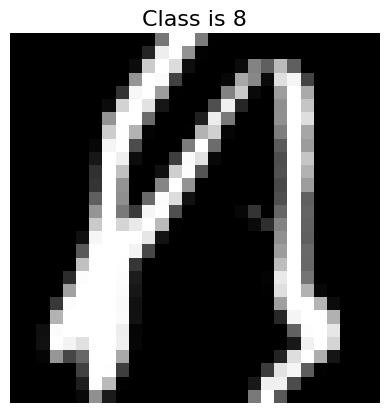

In [ ]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





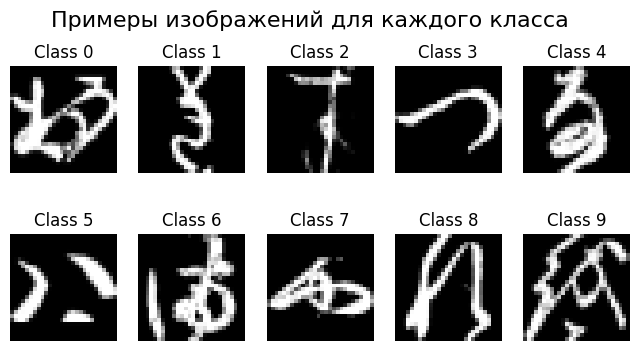

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Примеры изображений для каждого класса', fontsize=16)

for i in range(10):
    idx = next(iter(idx for idx, label in enumerate(trainset.targets) if label == i))
    image, label = trainset[idx]
    axs[i // 5, i % 5].imshow(image.squeeze(), cmap='gray')
    axs[i // 5, i % 5].set_title(f'Class {label}')
    axs[i // 5, i % 5].axis('off')

plt.show()


<font size=3 color='purple'><b>Гут 2/2 </font>

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)  # Последний слой, количество признаков равно количеству классов
        self.activation = nn.ReLU()  # Функция активации ReLU


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        logits = self.fc3(x)

        # if self.last_activation is not None:
        #     logits = self.last_activation(logits) # last_activation = None

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [ ]:
fc1 = 28*28*256
fc2 =  128 * 256
fc3 = 10 * 128
print('weights =', fc1, fc2, fc3)
bias = 256+128+10
print('bias =', bias)
summ_all = fc1 + fc2 + fc3 + bias
print('all parameters =', summ_all)

weights = 200704 32768 1280
bias = 394
all parameters = 235146


<font size=3 color='purple'><b>Гут 4/4</font>

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [ ]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [ ]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [ ]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch=1 loss=0.8997
Epoch=2 loss=0.4443
Epoch=3 loss=0.3448
Epoch=4 loss=0.2843
Epoch=5 loss=0.2413
Epoch=6 loss=0.2079
Epoch=7 loss=0.1809
Epoch=8 loss=0.1594
Epoch=9 loss=0.1393
Epoch=10 loss=0.1234


In [ ]:
get_accuracy(fc_net, testloader)

0.8746

<font size=3 color='purple'><b>Советую при работе с сетями всегда отрисовывать на графике эволюцию лосса и метрик. Это очень наглядно. Когда эпох много, текст не разобрать. И еще, на будущее цикл обучения удобно все же обернуть в функцию (в идеале в класс), в которую передается модель, оптимизатор и прочие параметры. Обучение может быть очень громоздким кодом и чтобы его не копипастить, лучше выносить в функцию. 5/5</font>

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = trainset.data.float().mean() / 255 ## calculate mean
std = train_std = trainset.data.float().std() / 255 ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


<font size=3 color='purple'><b>Советую посмотреть как считать среднее и стандартное отклонение по батчам постепенно. Представь, что у тебя очень большие данные. Тогда такой метод не прокатит из-за перегрузки памяти</font>

In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6845
Epoch=2 loss=0.3045
Epoch=3 loss=0.2260
Epoch=4 loss=0.1760
Epoch=5 loss=0.1402
Epoch=6 loss=0.1142
Epoch=7 loss=0.0941
Epoch=8 loss=0.0773
Epoch=9 loss=0.0636
Epoch=10 loss=0.0513


In [ ]:
get_accuracy(fc_net, testloader)

0.8999

Как изменилась `accuracy` после нормализации?

Стало получше немного

<font size=3 color='purple'><b>3/3</font>

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
def train_and_evaluate_model(activation_func):
    fc_net = FCNet()
    fc_net.activation = activation_func
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

    n_epochs = 10
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

    accuracy = get_accuracy(fc_net, testloader)
    print(f"Accuracy for {activation_func.__class__.__name__}: {accuracy:.4f}")

activation_functions = [nn.Sigmoid(), nn.Tanh(), nn.GELU(approximate='none')]

for activation_func in activation_functions:
    train_and_evaluate_model(activation_func)

Epoch=1 loss=1.5513
Epoch=2 loss=0.7511
Epoch=3 loss=0.5468
Epoch=4 loss=0.4444
Epoch=5 loss=0.3750
Epoch=6 loss=0.3213
Epoch=7 loss=0.2785
Epoch=8 loss=0.2437
Epoch=9 loss=0.2146
Epoch=10 loss=0.1890
Accuracy for Sigmoid: 0.8518
Epoch=1 loss=0.7648
Epoch=2 loss=0.3840
Epoch=3 loss=0.2624
Epoch=4 loss=0.1888
Epoch=5 loss=0.1409
Epoch=6 loss=0.1055
Epoch=7 loss=0.0798
Epoch=8 loss=0.0596
Epoch=9 loss=0.0439
Epoch=10 loss=0.0325
Accuracy for Tanh: 0.8954
Epoch=1 loss=0.6557
Epoch=2 loss=0.2833
Epoch=3 loss=0.2070
Epoch=4 loss=0.1593
Epoch=5 loss=0.1233
Epoch=6 loss=0.0984
Epoch=7 loss=0.0789
Epoch=8 loss=0.0631
Epoch=9 loss=0.0505
Epoch=10 loss=0.0400
Accuracy for GELU: 0.9040


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Похоже, что с GELU лучше всего получается.

<font size=3 color='purple'><b>3/3 Вот тут график очень хорошо бы смотрелся. Почитай теорию в гугле, чем отличаются активации, проверь, что ты понимаешь, что за ними стоит</font>

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [ ]:
def train_and_evaluate_with_optimizer(optimizer):

    fc_net = FCNet()
    fc_net.activation = nn.GELU()

    loss_function = nn.CrossEntropyLoss()
    lr = 0.001

    optimizer = optimizer(fc_net.parameters(), lr=lr)

    n_epochs = 10
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_history.append(epoch_loss / len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

    accuracy = get_accuracy(fc_net, testloader)
    print(f"Accuracy with {optimizer.__class__.__name__}: {accuracy:.4f}")

optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]

for optimizer in optimizers:
    train_and_evaluate_with_optimizer(optimizer)

Epoch=1 loss=0.4313
Epoch=2 loss=0.1695
Epoch=3 loss=0.1061
Epoch=4 loss=0.0715
Epoch=5 loss=0.0466
Epoch=6 loss=0.0306
Epoch=7 loss=0.0204
Epoch=8 loss=0.0149
Epoch=9 loss=0.0126
Epoch=10 loss=0.0152
Accuracy with Adam: 0.8995
Epoch=1 loss=0.3484
Epoch=2 loss=0.1400
Epoch=3 loss=0.0888
Epoch=4 loss=0.0570
Epoch=5 loss=0.0379
Epoch=6 loss=0.0298
Epoch=7 loss=0.0207
Epoch=8 loss=0.0184
Epoch=9 loss=0.0168
Epoch=10 loss=0.0113
Accuracy with RMSprop: 0.9051
Epoch=1 loss=0.6925
Epoch=2 loss=0.4397
Epoch=3 loss=0.3838
Epoch=4 loss=0.3510
Epoch=5 loss=0.3276
Epoch=6 loss=0.3099
Epoch=7 loss=0.2961
Epoch=8 loss=0.2840
Epoch=9 loss=0.2734
Epoch=10 loss=0.2647
Accuracy with Adagrad: 0.8181


Получается, что с Adam accuracy выше всего

<font size=3 color='purple'><b>4/4 Тут он не сильно отличается от RMSprop, но в целом да он мощнее, так как сочетает свойства двух других</font>

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        return torch.max(torch.tensor(0.0), x)

<font size=3 color='purple'><b>Или `x[x < 0] = 0`</font>

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [ ]:
def train_and_evaluate_with_optimizer(optimizer):
    fc_net_custom_relu = FCNet()
    fc_net_custom_relu.activation = CustomReLU()
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer_custom_relu = optimizer(fc_net_custom_relu.parameters(), lr=3e-4)

    n_epochs = 10
    loss_history_custom_relu = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader:
            optimizer_custom_relu.zero_grad()
            outputs = fc_net_custom_relu(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer_custom_relu.step()

            epoch_loss += loss.item()

        loss_history_custom_relu.append(epoch_loss / len(trainloader))
        print(f"Epoch={epoch + 1} loss={loss_history_custom_relu[epoch]:.4f}")

    accuracy_custom_relu = get_accuracy(fc_net_custom_relu, testloader)
    print("Accuracy with CustomReLU:", accuracy_custom_relu)


In [ ]:
train_and_evaluate_with_optimizer(torch.optim.Adam)

Epoch=1 loss=0.6839
Epoch=2 loss=0.3001
Epoch=3 loss=0.2205
Epoch=4 loss=0.1702
Epoch=5 loss=0.1358
Epoch=6 loss=0.1101
Epoch=7 loss=0.0903
Epoch=8 loss=0.0733
Epoch=9 loss=0.0604
Epoch=10 loss=0.0487
Accuracy with CustomReLU: 0.8991


Получилось ровно также, как в нормализованном nn.ReLU, и повыше, чем у просто nn.ReLU

<font size=3 color='purple'><b>4/4 Вообще предполагалось, что вы обучаете модель, считаете точность на тесте, меняете активацию в обученной модели (для этого активация должна быть параметром класса), считаете точность еще раз и вот у вас два однаковых числа. Ну ок. (Если что ты не активацию нормализуешь)</font>

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Использовала модель Kandinsky 3.0

Смысл жизни в стиле khokhloma (все еще секрет, получается)

![Смысл жизни.jpg](attachment:510dee69-4788-4966-aec6-47fb9414af9b.jpg)

The Answer to the Ultimate Question of Life, the Universe, and Everything - oil_painting

![The Answer to the Ultimate Question of Life, the Universe, and Everything_Kandinsky 3.0.jpg](attachment:6d2089d5-0777-4ec4-8ef7-86691410f4da.jpg)

Мария Узун не сохранила ноутбук с предсказаниями по игре в доту. Картина маслом

![Мария Узун не сохранила ноутбук с предсказаниями по игре в доту_Kandinsky 3.0.jpg](attachment:2db2ce96-90f7-4552-a905-f555a314f7d1.jpg)

<font size=3 color='purple'><b>Если картинки просто копипастить, то они потом не отображаются. Надо их вставлять как ссылки на папки с файлами (и файлы соответственно тоже прикреплять) 1/3</font>